C:\Users\dhaks\AppData\Local\Temp\ipykernel_28632\729512833.py:21: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('city_temperature.csv')



 Training started — running on GPU...

Epoch 1/20


c:\Users\dhaks\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35334/35334 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 0.0601 - val_loss: 0.0873
Epoch 2/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 0.0534 - val_loss: 0.0878
Epoch 3/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 0.0531 - val_loss: 0.0875
Epoch 4/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 0.0530 - val_loss: 0.0866
Epoch 5/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 0.0529 - val_loss: 0.0877
Epoch 6/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 0.0531 - val_loss: 0.0870
Epoch 7/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 0.0528 - val_loss: 0.0870
Epoch 8/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 0.0526 - val_loss: 0.0874
Epoch 9/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 0.0528 - val_loss: 0.0875
Epoch 10/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 50s 1ms/step - loss: 0.0526 - val_loss: 0.0866
Epoch 11/20
35334/35334 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 0.0527 - val_loss: 0.0875
Epoch 12

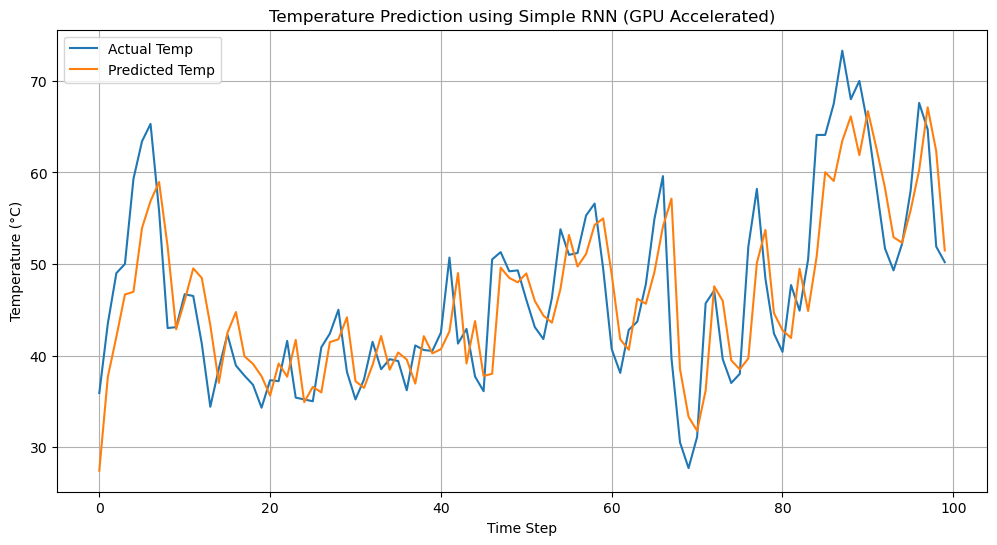


✅ Mean Squared Error: 31.6643


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(logical_gpus)} Logical GPU(s) available.")
    except RuntimeError as e:
        print(e)

df = pd.read_csv('city_temperature.csv')

df['Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str),
    format='%Y-%m-%d',
    errors='coerce'
)

df = df.dropna(subset=['Date'])
df = df[['Date', 'AvgTemperature']]
df.rename(columns={'Date': 'date_time', 'AvgTemperature': 'tempC'}, inplace=True)
df.set_index('date_time', inplace=True)
df = df[df['tempC'] != -99]

scaler = StandardScaler()
df['tempC_scaled'] = scaler.fit_transform(df[['tempC']])

def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10
X, y = create_sequences(df['tempC_scaled'].values, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential([
    SimpleRNN(32, input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

print("\n Training started — running on GPU...\n")
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=64)

y_pred = model.predict(X_test)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:100], label='Actual Temp')
plt.plot(y_pred_original[:100], label='Predicted Temp')
plt.title("Temperature Prediction using Simple RNN (GPU Accelerated)")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test_original, y_pred_original)
print(f"\n Mean Squared Error: {mse:.4f}")